# Import Dependencies

In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from moviepy.editor import *
import time
from os.path import basename
from scipy.ndimage.measurements import label
%matplotlib inline

# Load Data
<span style="color:red">NOTE: this uses a glob recursive search which needs py 3.5 or higher</span>.


In [2]:
vehicle_dir = 'vehicles'
non_vehicle_dir = 'non-vehicles'

vehicle_image_paths = glob('{}/**/*'.format(vehicle_dir))
non_vehicle_image_paths = glob('{}/**/*'.format(non_vehicle_dir))

print('number of vehicle images: {}'.format(len(vehicle_image_paths)))
print('number of vehicle images: {}'.format(len(non_vehicle_image_paths)))

number of vehicle images: 8792
number of vehicle images: 8968


# Provided Lesson Code

In [3]:
def color_hist(image, nbins=32):
    hist_image = convert_color(image, color_space='RGB')
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))


def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    feature_image = convert_color(img, color_space=color_space)       
    # Use cv2.resize().ravel() to create the feature vector
    return cv2.resize(feature_image, size).ravel() 


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):
    return hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Define a function that takes an image,
    start and stop positions in both x and y, 
    window size (x and y dimensions),  
    and overlap fraction (for both x and y)
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Iterate through the bounding boxes
    image_copy = np.copy(img)
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(image_copy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return image_copy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space=color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if hog_channel != 'ALL':
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
    
def convert_color(image, color_space='RGB'):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        return np.copy(image)
            

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = plt.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space=color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(
    image,
    ystart, 
    ystop,
    scale, 
    svc, 
    X_scaler,
    color_space='RGB',
    orient=9, 
    pix_per_cell=8, 
    cell_per_block=2,
    cells_per_step=2, # Instead of overlap, define how many cells to step
    spatial_size=(32, 32), 
    hist_bins=32
):
    image = image.astype(np.float32)/255
    image_to_search = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(image_to_search, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return boxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(image, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return image

# View Raw Images

vehicle image num: 3018 non vehicle image num: 6458


Text(0.5,1,'Vehicle Image')

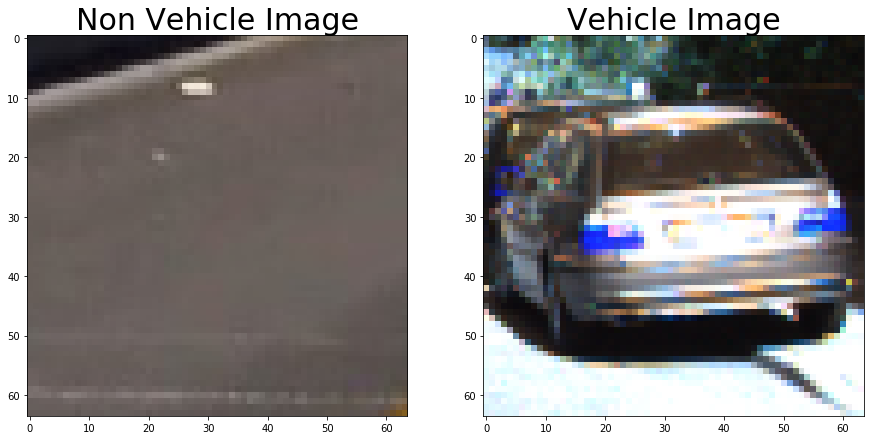

In [4]:
vehicle_image_num = np.random.randint(0, len(vehicle_image_paths))
non_vehicle_num = np.random.randint(0, len(non_vehicle_image_paths))
print('vehicle image num: {} non vehicle image num: {}'.format(vehicle_image_num, non_vehicle_num))

vehicle_image = plt.imread(vehicle_image_paths[vehicle_image_num])
vehicle_image = cv2.cvtColor(vehicle_image, cv2.COLOR_BGR2RGB)
non_vehicle_image = plt.imread(non_vehicle_image_paths[non_vehicle_num])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.imshow(non_vehicle_image)
ax1.set_title('Non Vehicle Image', fontsize=30)
ax2.imshow(vehicle_image)
ax2.set_title('Vehicle Image', fontsize=30)

# Visualize HOG Image

In [5]:
def visualize_hog(color_space):
    vehicle_features_ch1, vehicle_hog_image_ch1 = single_img_features(
    vehicle_image, 
    color_space=color_space, 
    hog_channel=0
    )

    vehicle_features_ch2, vehicle_hog_image_ch2 = single_img_features(
        vehicle_image, 
        color_space=color_space, 
        hog_channel=1
    )

    vehicle_features_ch3, vehicle_hog_image_ch3 = single_img_features(
        vehicle_image, 
        color_space=color_space, 
        hog_channel=2
    )

    non_vehicle_features_ch1, non_vehicle_hog_image_ch1 = single_img_features(
        non_vehicle_image, 
        color_space=color_space, 
        hog_channel=0
    )

    non_vehicle_features_ch2, non_vehicle_hog_image_ch2 = single_img_features(
        non_vehicle_image, 
        color_space=color_space, 
        hog_channel=1
    )

    non_vehicle_features_ch3, non_vehicle_hog_image_ch3 = single_img_features(
        non_vehicle_image, 
        color_space=color_space, 
        hog_channel=2
    )
    
    f, axes = plt.subplots(2, 3, figsize=(15,8))
    axes[0, 0].imshow(non_vehicle_hog_image_ch1)
    axes[0, 0].set_title('Non Vehicle HOG Channel 1')

    axes[0, 1].imshow(non_vehicle_hog_image_ch2)
    axes[0, 1].set_title('Non Vehicle HOG Channel 2')

    axes[0, 2].imshow(non_vehicle_hog_image_ch3)
    axes[0, 2].set_title('Non Vehicle HOG Channel 3')

    axes[1, 0].imshow(vehicle_hog_image_ch1)
    axes[1, 0].set_title('Vehicle HOG Channel 1')

    axes[1, 1].imshow(vehicle_hog_image_ch2)
    axes[1, 1].set_title('Vehicle HOG Channel 2')

    axes[1, 2].imshow(vehicle_hog_image_ch3)
    axes[1, 2].set_title('Vehicle HOG Channel 3')



# YCrCb

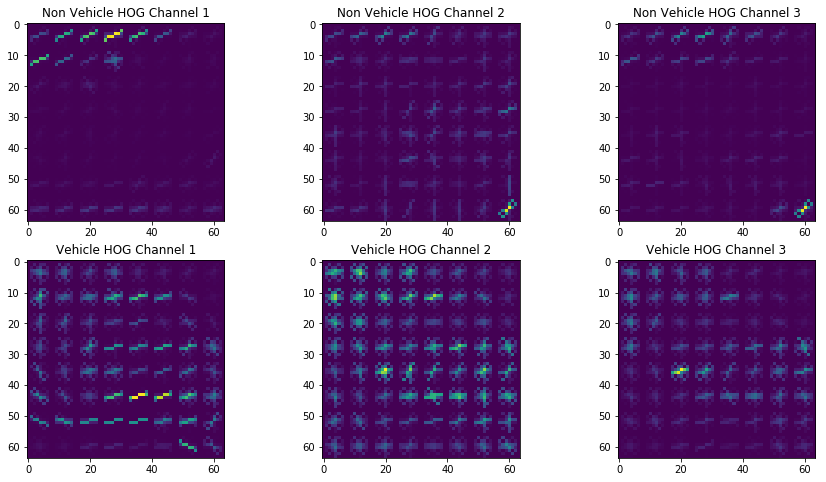

In [6]:
visualize_hog('YCrCb')

# RGB

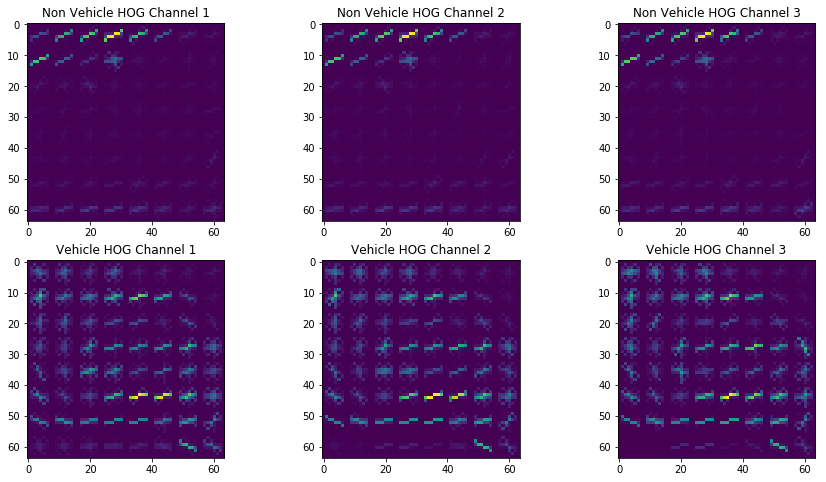

In [7]:
visualize_hog('RGB')

# HSV

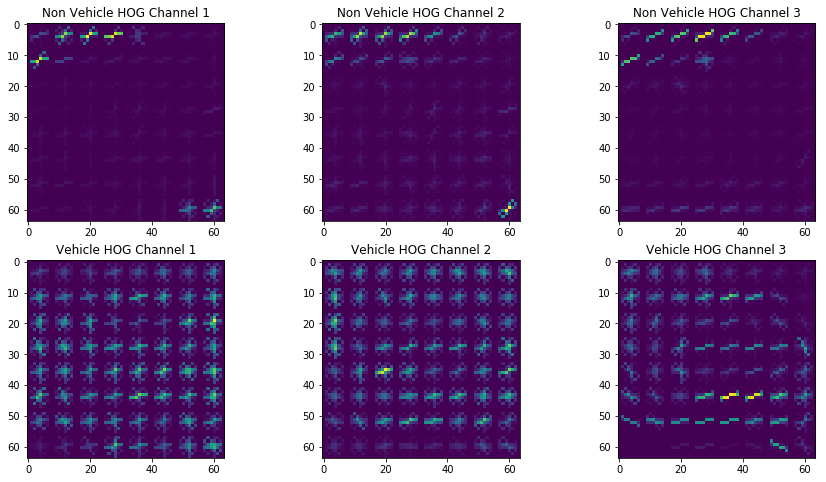

In [8]:
visualize_hog('HSV')

# HLS

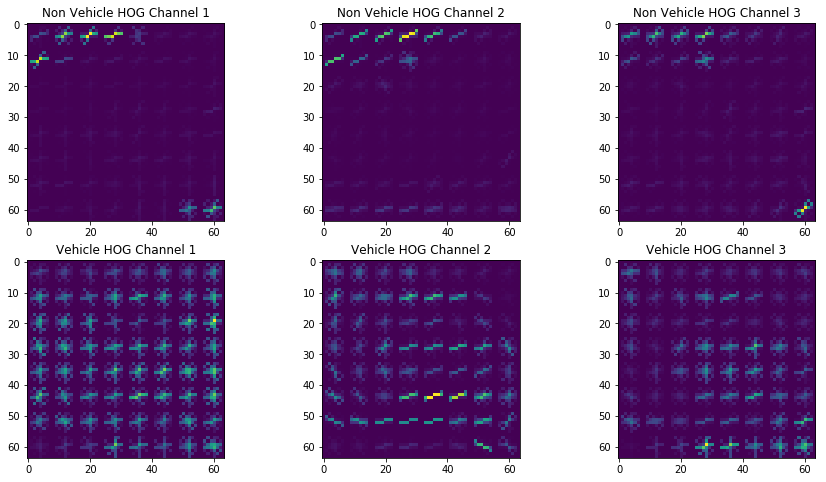

In [9]:
visualize_hog('HLS')

# YUV

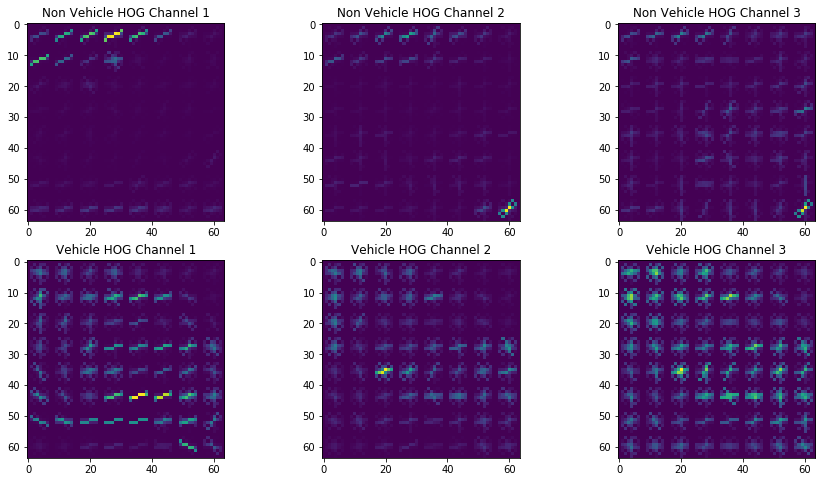

In [10]:
visualize_hog('YUV')

# LUV

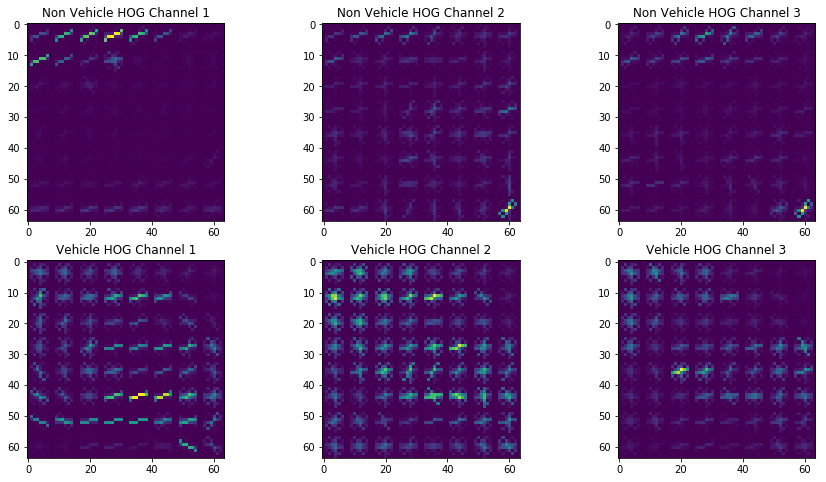

In [11]:
visualize_hog('LUV')

# Train and Validate

In [12]:
color_space = 'YCrCb'
orient = 9
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

# Get time prior to feature extraction.
t=time.time()

vehicle_features = extract_features(
    vehicle_image_paths, 
    color_space=color_space,
    orient=orient,
    cell_per_block=cell_per_block,
    pix_per_cell=pix_per_cell,
    hog_channel=hog_channel,
    spatial_size=spatial_size,
    hist_bins=hist_bins,
    spatial_feat=spatial_feat,
    hist_feat=hist_feat,
    hog_feat=hog_feat
)

non_vehicle_features = extract_features(
    non_vehicle_image_paths, 
    color_space=color_space,
    orient=orient,
    cell_per_block=cell_per_block,
    pix_per_cell=pix_per_cell,
    hog_channel=hog_channel,
    spatial_size=spatial_size,
    hist_bins=hist_bins,
    spatial_feat=spatial_feat,
    hist_feat=hist_feat,
    hog_feat=hog_feat
)

# Get time to after feature extraction completes.
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler to training data only to normalize different types of feature extraction.
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X for both train and test sets.
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Create a classifier.
# svc = LinearSVC(C=2, penalty='l1', loss='squared_hinge', dual=False)
svc = LinearSVC(C=2, loss='hinge')

# svc = SVC(kernel='rbf', C=10)

# Train and get training time.
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

95.61 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
27.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.10944 Seconds to predict 10 labels with SVC


# Window Search Via Sub-Sampling

Instead of extracting the `HOG` sample for every window, here the `find cars` will take one `HOG` sample for each `region of interest`.

## Filter Out False Positives and Duplicates

- Use heat maps to see where the highest occurence of positives are located and merge dups.
- Theshold heat maps to filter out false positives.
- Apply HOG to whole region of interest and sub sample each window to increase perf.

2 cars found
9 cars found
10 cars found
11 cars found
11 cars found
12 cars found
10 cars found


Text(0.5,1,'labeled heatmap')

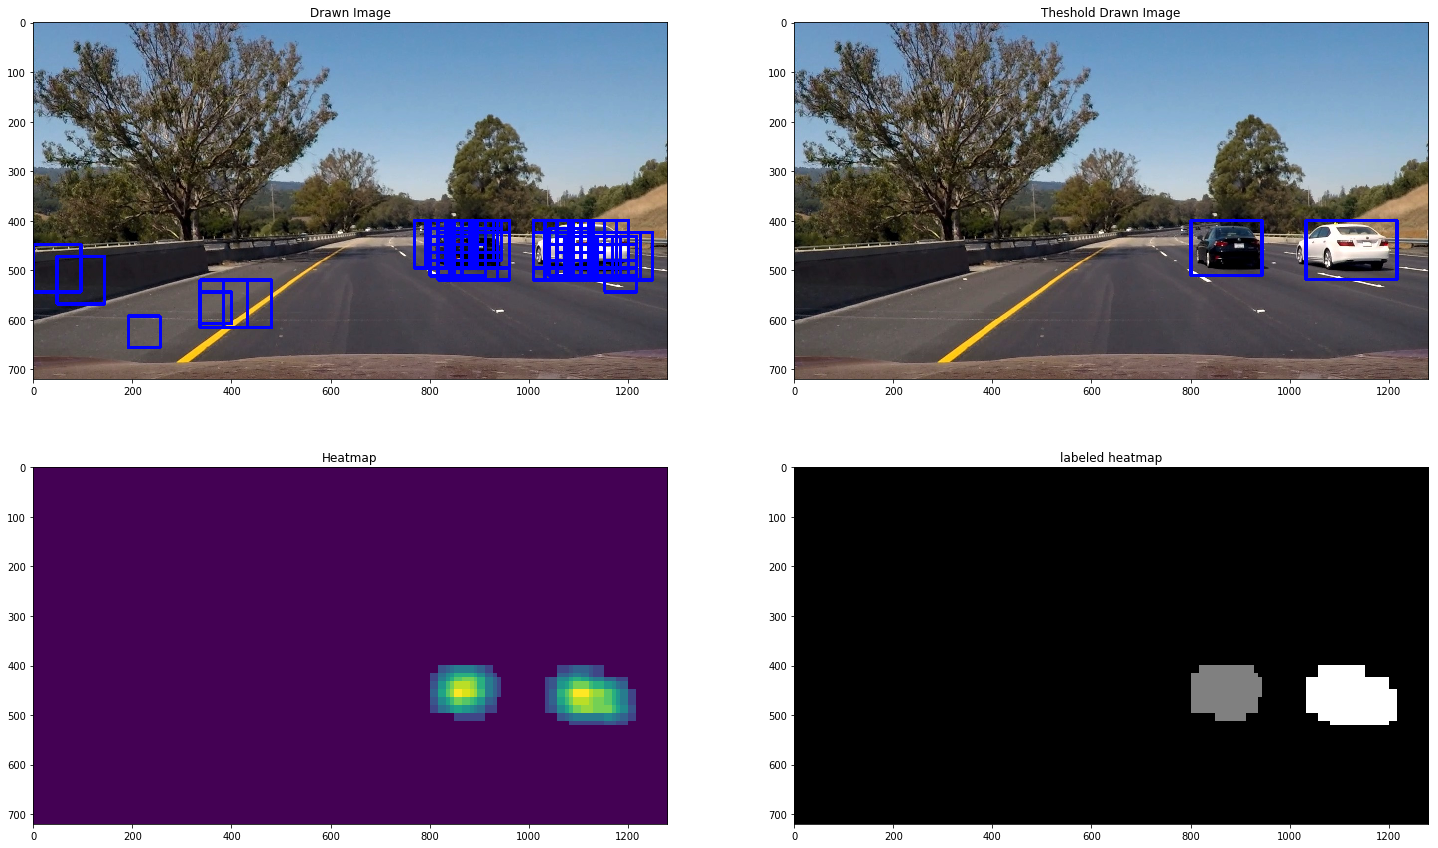

In [16]:
base_path = 'test_images'
paths = glob('{}/*'.format(base_path))
output_base_path = 'test_images_with_boxes'
cells_per_step = 2
heat_threshhold = 3
y_start = 400
y_stop = 656
images = []
heatmaps = []
labeled_images = []
thesh_images = []

scales = [1., 1.5]
boxes = []

for path in paths[:]:
    t1 = time.time()
    image = plt.imread(path)
    
    for i, scale in enumerate(scales):
        boxes += find_cars(
            image,
            y_start, 
            y_stop,
            scale, 
            svc, 
            X_scaler,
            color_space=color_space,
            orient=orient, 
            pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            cells_per_step=cells_per_step,
            spatial_size=spatial_size, 
            hist_bins=hist_bins
        )
    
    drawn_image = draw_boxes(image, boxes)
    
    heatmap = np.zeros_like(image[:, :, 0])
    add_heat(heatmap, boxes)
    heatmap = apply_threshold(heatmap, heat_threshhold)
    
    labels = label(heatmap)
    print(labels[1], 'cars found')

    thesh_drawn_image = draw_labeled_bboxes(image, labels)
    
    images.append(drawn_image)
    thesh_images.append(thesh_drawn_image)
    heatmaps.append(heatmap)
    labeled_images.append(labels[0])
    
    plt.imsave('sub_sample/{}'.format(basename(path)), thesh_drawn_image)
    plt.imsave('sub_sample/heatmap-{}'.format(basename(path)), heatmap)
    
test_image_num = 0
f, axes = plt.subplots(2, 2, figsize=(25,15))
axes[0, 0].imshow(images[test_image_num])
axes[0, 0].set_title('Drawn Image')
axes[0, 1].imshow(thesh_images[test_image_num])
axes[0, 1].set_title('Theshold Drawn Image')
axes[1, 0].imshow(heatmaps[test_image_num])
axes[1, 0].set_title('Heatmap') 
axes[1, 1].imshow(labeled_images[test_image_num], cmap='gray')
axes[1, 1].set_title('labeled heatmap')

# Create Video Pipeline

In [14]:
from collections import deque

class HeatMap:
    def __init__(self, max_size=10):
        self.heatmap_queue = deque(maxlen=max_size)
        self.max_size = max_size
        
    def add_heat(self, image, boxes):
        heatmap = np.zeros_like(image[:, :, 0])    
        heatmap = add_heat(heatmap, boxes)
        self.heatmap_queue.append(heatmap)
        
    def get_heatmap(self):
        mask = np.count_nonzero(self.heatmap_queue, axis=0)
        mask = mask < self.max_size
        avg = np.average(np.square(self.heatmap_queue), axis=0)
        avg[mask] = 0
        return avg

    
class VideoPipeLine:
    def __init__(self):
        self.heatmap = HeatMap(max_size=25)

    def process_image(self, image):
        boxes = []
        for scale in scales:
            boxes += find_cars(
                image,
                y_start, 
                y_stop,
                scale, 
                svc, 
                X_scaler,
                color_space=color_space,
                orient=orient, 
                pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, 
                cells_per_step=cells_per_step,
                spatial_size=spatial_size, 
                hist_bins=hist_bins
            )

        self.heatmap.add_heat(image, boxes)
        heatmap = apply_threshold(self.heatmap.get_heatmap(), heat_threshhold)
        labels = label(heatmap)
        thesh_drawn_image = draw_labeled_bboxes(image, labels)

        return thesh_drawn_image
    
    def process_video(self, input_path, output_path):
        source_video = VideoFileClip(input_video_path)
        processed_video = source_video.fl_image(self.process_image)
        processed_video.write_videofile(output_video_path, audio=False)

In [15]:
heat_threshhold = 23

input_video_path = 'project_video.mp4'
output_video_path = 'drawn_project_video.mp4'

VideoPipeLine().process_video(input_video_path, output_video_path)

[MoviePy] >>>> Building video drawn_project_video.mp4
[MoviePy] Writing video drawn_project_video.mp4


100%|█████████▉| 1260/1261 [43:13<00:02,  2.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: drawn_project_video.mp4 

